In [1]:
import os
import glob
import uproot
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import gridspec
from scipy.optimize import curve_fit
import mplhep as hep
plt.style.use(hep.style.CMS)
import yahist
from tqdm import tqdm

plt.rcParams.update({"figure.facecolor": (1,1,1,0)})

PLOTS_DIR = "/home/users/jguiang/public_html/lhe_plots/vbswh/"
os.makedirs(PLOTS_DIR, exist_ok=True)

In [2]:
lumi_inv_fb = 138

def get_lhe_dfs(lhe_babies, lumi_invfb=138):
    dfs = []
    xsec_df = []
    kW, kZ = (-999, -999)
    for lhe_baby in tqdm(lhe_babies):
        name = lhe_baby.split("/")[-1].replace(".root", "")
        if name == "VBSWH":
            kW, kZ = (1, 1)
        elif "VBSWH_kWkZscan" in name:
            continue
        elif name == "VBSWH_kWscan_kZscan_m1p5_to_m0p5":
            continue
        else:
            if "mkW" in name:
                kW, kZ = (-1, 1)
            elif "mkZ" in name:
                kW, kZ = (1, -1)
            else:
                kV = float(name.split("_")[-1].split("k")[0].replace("p", ".").replace("m", "-"))
                if "kW" in name:
                    kW, kZ = (kV, 1)
                elif "kZ" in name:
                    kW, kZ = (1, kV)
        with uproot.open(lhe_baby) as f:
            xsec_pb = f["Processes"].arrays()[0]["XSECUP"]
            xsec_err = f["Processes"].arrays()[0]["XERRUP"]
        with uproot.open(lhe_baby) as f:
            df = f.get("tree").arrays(library="pd")
            df["xsec_weight"] = (1000*xsec_pb*lumi_invfb)/len(df)
            df["name"] = name
            
        dfs.append(df)
        xsec_df.append({"name": name, "kW": kW, "kZ": kZ, "xsec": xsec_pb, "xsec_err": xsec_err})
        
    return pd.concat(dfs), pd.DataFrame(xsec_df)

df, xsec_df = get_lhe_dfs(glob.glob("../analysis/studies/lhe_vbswh/output/*.root"))

xsec_df

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 24/24 [00:02<00:00,  9.58it/s]


,name,kW,kZ,xsec,xsec_err
0,VBSWH_0kW,0.0,1.0,0.108180,0.000344
1,VBSWH_0kZ,1.0,0.0,0.144603,0.000413
2,VBSWH_0p1kW,0.1,1.0,0.091963,0.000302
3,VBSWH_0p1kZ,1.0,0.1,0.128058,0.000401
4,VBSWH_0p5kW,0.5,1.0,0.055261,0.000171
5,VBSWH_0p5kZ,1.0,0.5,0.082285,0.000257
6,VBSWH_1p5kW,1.5,1.0,0.165143,0.000490
7,VBSWH_1p5kZ,1.0,1.5,0.120517,0.000373
8,VBSWH_2kW,2.0,1.0,0.329175,0.001026
9,VBSWH_2kZ,1.0,2.0,0.221120,0.000687


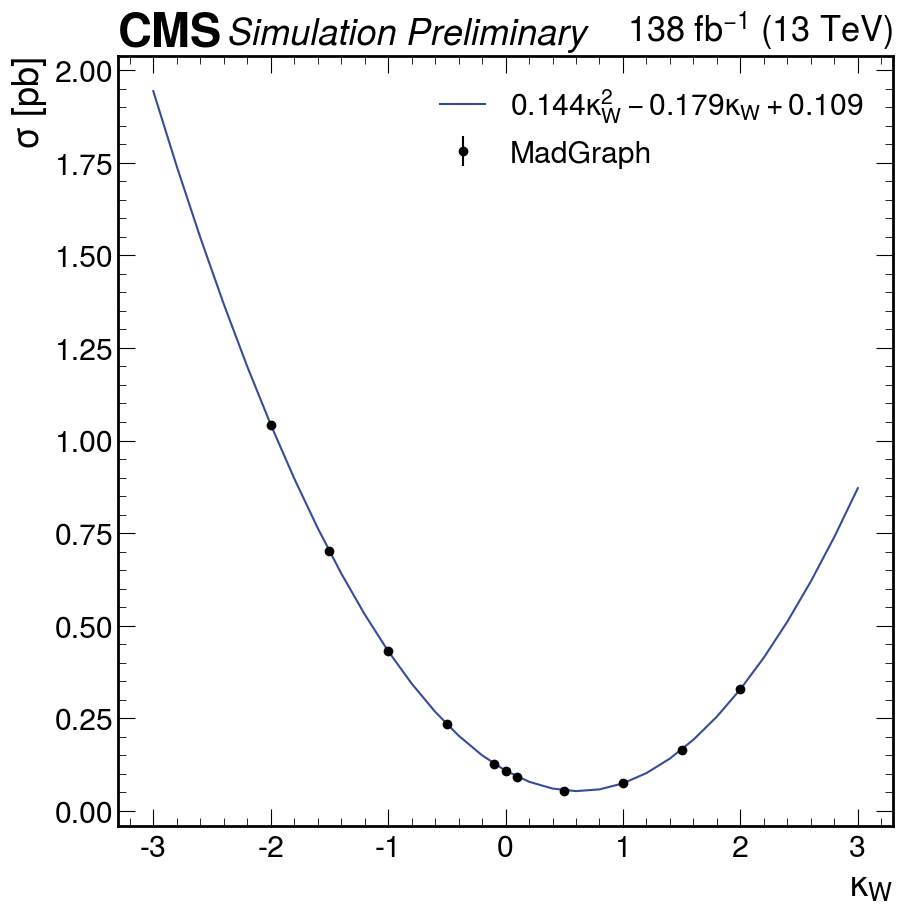

In [3]:
kappas = xsec_df[xsec_df.kZ == 1].kW
xsecs = xsec_df[xsec_df.kZ == 1].xsec

parabola = lambda x, A, B, C: A*x**2 + B*x + C
opt_params, _ = curve_fit(parabola, kappas, xsecs, p0=[1, 1, 0.108])
A, B, C = opt_params

fig, axes = plt.subplots();
axes.errorbar(
    kappas, xsecs, yerr=xsec_df[xsec_df.kZ == 1].xsec_err, 
    fmt="ko", label="MadGraph"
);
axes.plot(
    np.linspace(-3, 3, 31), [parabola(x, A, B, C) for x in np.linspace(-3, 3, 31)], 
    color="#364b9a",
    label=(r"$A\kappa_W^2 B\kappa_W C$".replace("A", f"{A:0.3f}")
                                       .replace("B", f"{B:+0.3f}")
                                       .replace("C", f"{C:+0.3f}"))
);
axes.legend();

# Add CMS label
hep.cms.label(
    "Preliminary",
    data=False,
    lumi=138,
    loc=0,
    ax=axes,
)

axes.set_xlabel(r"$\kappa_W$");
axes.set_ylabel(r"$\sigma$ [pb]");

plt.savefig("/home/users/jguiang/public_html/vbswh_plots/lhe/kW_xsecs.pdf", bbox_inches="tight")

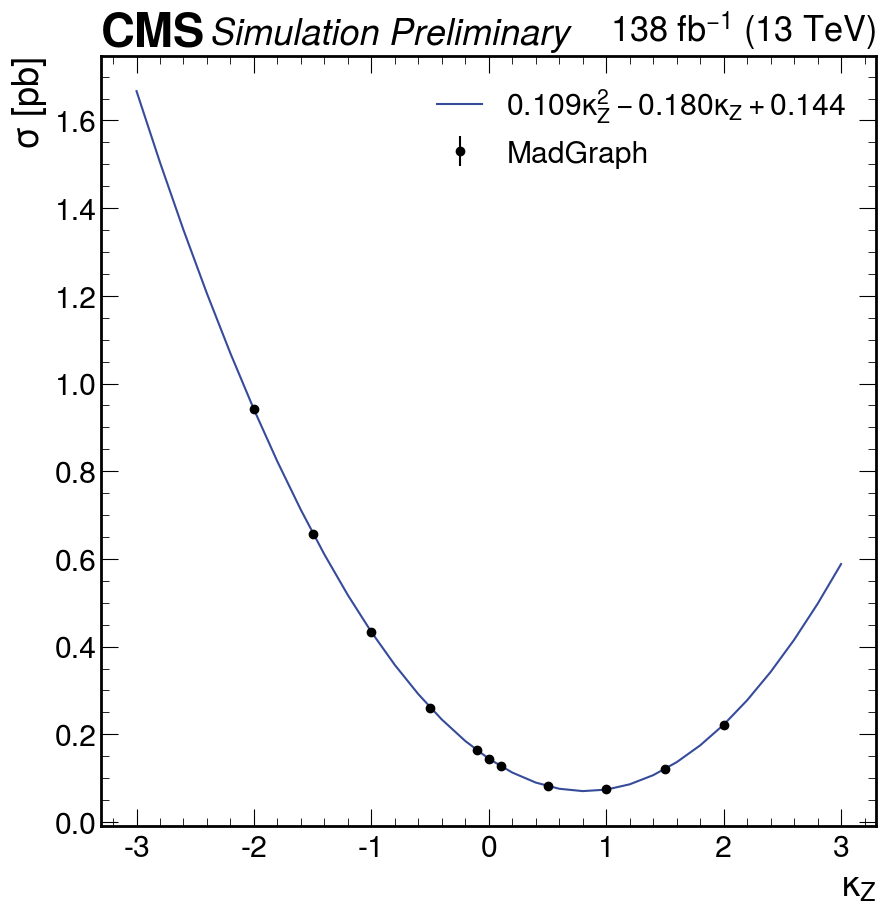

In [4]:
kappas = xsec_df[xsec_df.kW == 1].kZ
xsecs = xsec_df[xsec_df.kW == 1].xsec

parabola = lambda x, A, B, C: A*x**2 + B*x + C
opt_params, _ = curve_fit(parabola, kappas, xsecs, p0=[1, 1, 0.145])
A, B, C = opt_params

fig, axes = plt.subplots();
axes.errorbar(
    kappas, xsecs, yerr=xsec_df[xsec_df.kW == 1].xsec_err, 
    fmt="ko", label="MadGraph"
);
axes.plot(
    np.linspace(-3, 3, 31), [parabola(x, A, B, C) for x in np.linspace(-3, 3, 31)], 
    color="#364b9a",
    label=(r"$A\kappa_Z^2 B\kappa_Z C$".replace("A", f"{A:0.3f}")
                                       .replace("B", f"{B:+0.3f}")
                                       .replace("C", f"{C:+0.3f}"))
);
axes.legend();

# Add CMS label
hep.cms.label(
    "Preliminary",
    data=False,
    lumi=138,
    loc=0,
    ax=axes,
)

axes.set_xlabel(r"$\kappa_Z$");
axes.set_ylabel(r"$\sigma$ [pb]");

plt.savefig("/home/users/jguiang/public_html/vbswh_plots/lhe/kZ_xsecs.pdf", bbox_inches="tight")

In [5]:
df

,ld_Q_pz,tr_Q_pz,ld_Q_E,tr_Q_E,H_pt,H_eta,H_phi,W_pt,W_eta,W_phi,W_sign,W_pol,M_WH,ld_VBS_pt,tr_VBS_pt,M_jj,deta_jj,ST,xsec_weight,name
0,1644.906070,-1166.257186,1644.906070,1166.257186,364.994066,-0.017531,2.991497,775.752006,-0.016655,0.396742,1.0,0.0,1052.420030,418.936850,110.137013,1485.833032,3.896033,1140.746073,1.492884,VBSWH_0kW
1,1411.304257,-1883.035791,1411.304257,1883.035791,493.219773,-1.483540,1.508343,549.603135,0.715665,-1.702822,1.0,0.0,1748.610488,59.548598,18.173161,1435.724684,-7.552409,1042.822907,1.492884,VBSWH_0kW
2,1576.856197,-2255.035940,1576.856197,2255.035940,155.969838,-1.533538,-2.191816,216.263229,0.082206,1.114507,-1.0,0.0,534.121611,61.022662,48.597000,3182.052261,8.135604,372.233067,1.492884,VBSWH_0kW
3,1629.077110,-93.101279,1629.077110,93.101279,150.227079,1.721904,-2.255000,166.226859,1.791783,1.003815,1.0,0.0,381.466023,37.928434,15.737412,387.061580,5.518124,316.453937,1.492884,VBSWH_0kW
4,2038.947951,-79.614075,2038.947951,79.614075,30.449414,3.581139,-0.143784,71.969148,2.924555,-2.356209,1.0,0.0,233.255025,60.570321,10.880178,465.728476,5.795048,102.418562,1.492884,VBSWH_0kW
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,955.771517,-623.040360,955.771517,623.040360,217.929501,-0.040797,0.687975,105.608740,1.731777,-3.023673,-1.0,0.0,475.289290,136.503771,14.867516,998.072527,6.197161,323.538241,5.971232,VBSWH_mkZ
9996,742.094492,-701.994224,742.094492,701.994224,240.035432,1.205877,2.489412,201.218378,-0.886389,-1.707563,-1.0,-1.0,697.966328,128.145260,101.823299,644.197515,3.514268,441.253811,5.971232,VBSWH_mkZ
9997,567.553276,-1066.905038,567.553276,1066.905038,219.773800,-0.219617,-2.998515,296.615801,0.728763,-0.310342,-1.0,0.0,601.429000,120.643953,28.865267,699.261177,-4.952035,516.389601,5.971232,VBSWH_mkZ
9998,492.387574,-1283.617271,492.387574,1283.617271,406.249085,-0.695007,-1.981792,396.205408,-1.268269,1.196894,1.0,0.0,864.592219,23.031854,17.982498,460.005437,6.233681,802.454493,5.971232,VBSWH_mkZ


In [6]:
def smart_clip(np_array, bins):
    if len(bins) < 2:
        raise ValueError("must have at least two bins")
        return
    clip_low = 0.5 * (bins[0] + bins[1])
    clip_high = 0.5 * (bins[-2] + bins[-1])
    return np.clip(np_array, clip_low, clip_high)

def plot(df, var, hist_axes, bins=None, query="index >= 0", transf=lambda x: x, errors=False, 
         show_events=False, norm=False, label="", alpha=1.0, color=None, hatch=None,
         histtype="stepfilled", fmt="o"):
    
    hist = yahist.Hist1D(
        transf(df.query(query)[var]),
        bins=bins,
        weights=df.query(query).xsec_weight,
        label=(f"{label} [{np.sum(weights):0.1f} events]" if show_events and not norm else label),
        color=color
    )
    if norm:
        hist = hist.normalize()
        
    hist.plot(ax=hist_axes, histtype=histtype, alpha=alpha, errors=errors, fmt=fmt, hatch=hatch)
    return hist
    
def plot_all(var, bins=None, query="index >= 0", x_label="", transf=lambda x: x, 
             logy=False, show_events=False, norm=False, outfile=None, W_points=True,
             show_ratio=False):
    global df
    if show_ratio:
        fig = plt.figure()
        gs = gridspec.GridSpec(ncols=1, nrows=2, figure=fig, height_ratios=[2, 0.65], hspace=0.08)
        hist_axes = fig.add_subplot(gs[0])
        ratio_axes = fig.add_subplot(gs[1])
    else:
        fig, hist_axes = plt.subplots()
        
    if logy:
        hist_axes.set_yscale("log", nonpositive="clip")

    # Plot SM
    sm_hist = plot(
        df[df.name == "VBSWH"], var, hist_axes,
        bins=bins,
        query=query,
        transf=transf,
        errors=False,
        show_events=show_events,
        norm=norm,
        label="SM",
        color="#364b9a"
    )
        
    # Plot kW = 0.5
    plot(
        df[df.name == f"VBSWH_0p5k{'W' if W_points else 'Z'}"], var, hist_axes,
        bins=bins,
        query=query,
        transf=transf,
        errors=False,
        show_events=show_events,
        norm=norm,
        label=r"$\kappa_V = 0.5$".replace("V", "W" if W_points else "Z"),
        color="#97cae1",
        hatch="\\\\",
        histtype="step"
    )
    
    # Plot kW = -1
    mkW_hist = plot(
        df[df.name == "VBSWH_mkW"], var, hist_axes,
        bins=bins,
        query=query,
        transf=transf,
        errors=False,
        show_events=show_events,
        norm=norm,
        label=r"$\kappa_W = -1$",
        color="#f67e4b",
        hatch="/////",
        histtype="step"
    )
   
    # Plot kW = 0
    plot(
        df[df.name == f"VBSWH_0k{'W' if W_points else 'Z'}"], var, hist_axes,
        bins=bins,
        query=query,
        transf=transf,
        errors=True,
        show_events=show_events,
        norm=norm,
        label=r"$\kappa_V = 0$".replace("V", "W" if W_points else "Z"),
        color="#6ea5cd",
        histtype="step",
        fmt="s"
    )
    
    # Plot kW = -0.5
    plot(
        df[df.name == f"VBSWH_m0p5k{'W' if W_points else 'Z'}"], var, hist_axes,
        bins=bins,
        query=query,
        transf=transf,
        errors=True,
        show_events=show_events,
        norm=norm,
        label=r"$\kappa_V = -0.5$".replace("V", "W" if W_points else "Z"),
        color="#feda8a",
        histtype="step",
        fmt="o"
    )
    
    # Plot kW = -1.5
    plot(
        df[df.name == f"VBSWH_m1p5k{'W' if W_points else 'Z'}"], var, hist_axes,
        bins=bins,
        query=query,
        transf=transf,
        errors=True,
        show_events=show_events,
        norm=norm,
        label=r"$\kappa_V = -1.5$".replace("V", "W" if W_points else "Z"),
        color="#dd3c2d",
        histtype="step",
        fmt="^"
    )
    
    if show_ratio:
        # Plot (kW = -1)/SM ratio
        ratio_hist = mkW_hist/sm_hist
        ratio_hist.plot(ax=ratio_axes, errors=True, color="#f67e4b", zorder=1.2)

    # Plot legend
    hist_axes.legend();
    # Change axis labels
    hist_axes.set_ylabel("a.u." if norm else "Events");
    # Add CMS label
    hep.cms.label(
        "Preliminary",
        data=False,
        lumi=138,
        loc=0,
        ax=hist_axes,
    )
    
    if show_ratio:
        hist_axes.set_xticklabels([])
        ratio_axes.set_xlabel(x_label);
        ratio_axes.set_ylabel(r"$(\kappa_W = -1)/SM$")
        ratio_axes.set_yscale("log");
        ratio_axes.legend().remove()
    else:
        hist_axes.set_xlabel(x_label);
    
    if outfile:
        plt.savefig(outfile)
    
    return hist_axes

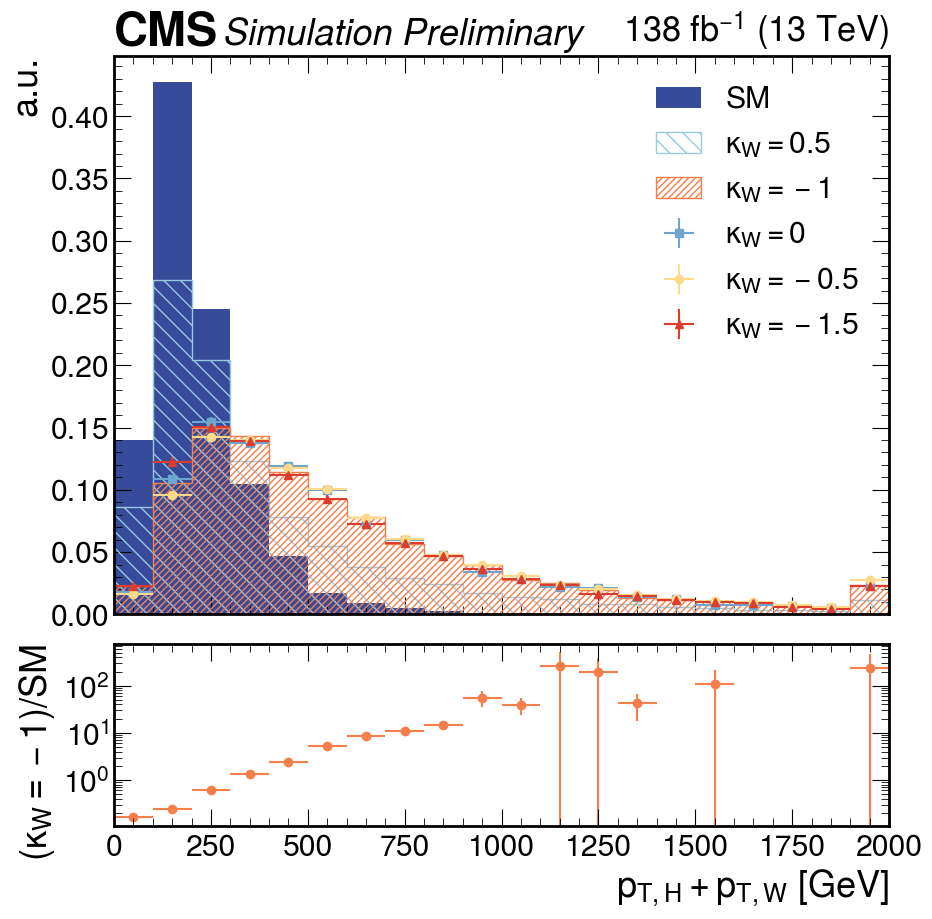

In [7]:
plot_all("ST", W_points=True, bins=np.linspace(0, 2000, 21), x_label="$p_{T,H} + p_{T,W}$ [GeV]", show_ratio=True, logy=False, norm=True, outfile=f"{PLOTS_DIR}/lhe_ST_kWpoints.pdf");

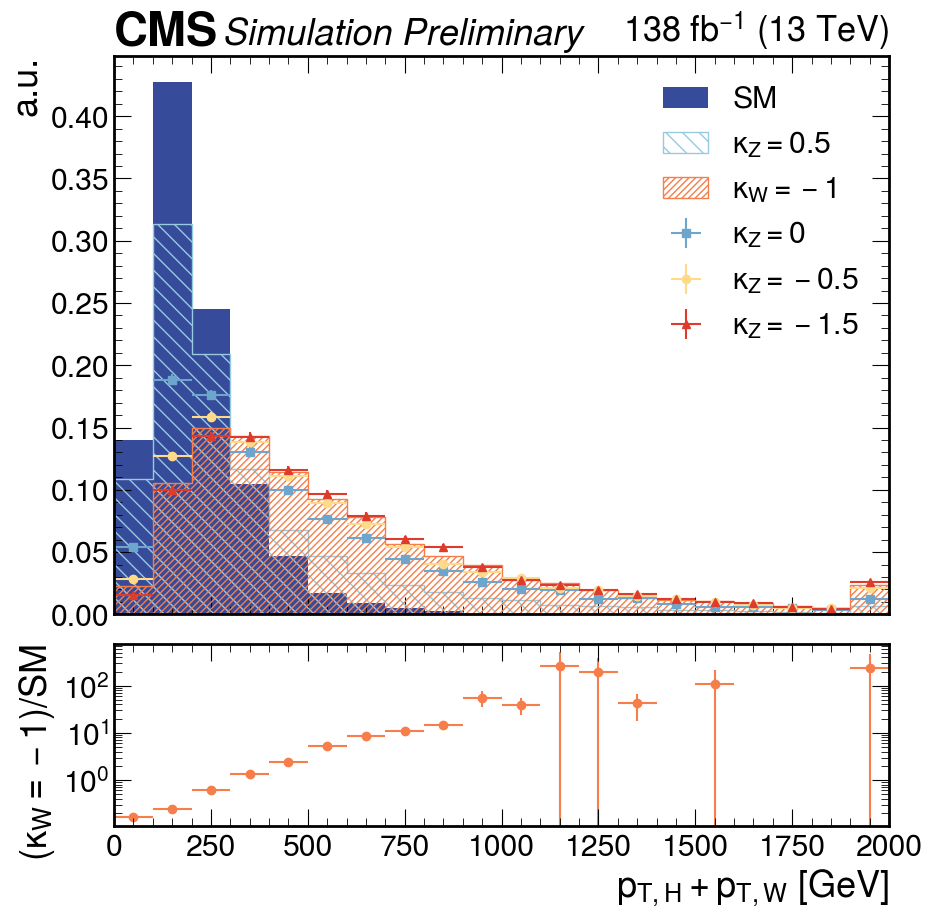

In [8]:
plot_all("ST", W_points=False, bins=np.linspace(0, 2000, 21), x_label="$p_{T,H} + p_{T,W}$ [GeV]", show_ratio=True, logy=False, norm=True, outfile=f"{PLOTS_DIR}/lhe_ST_kZpoints.pdf");

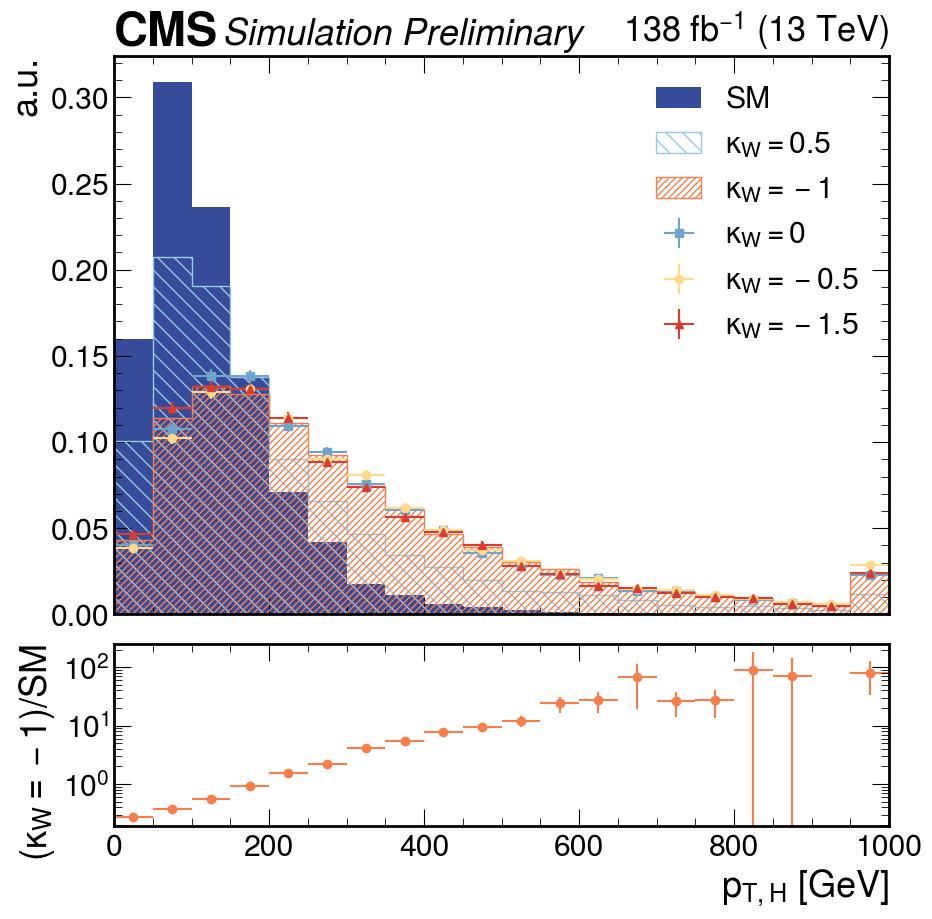

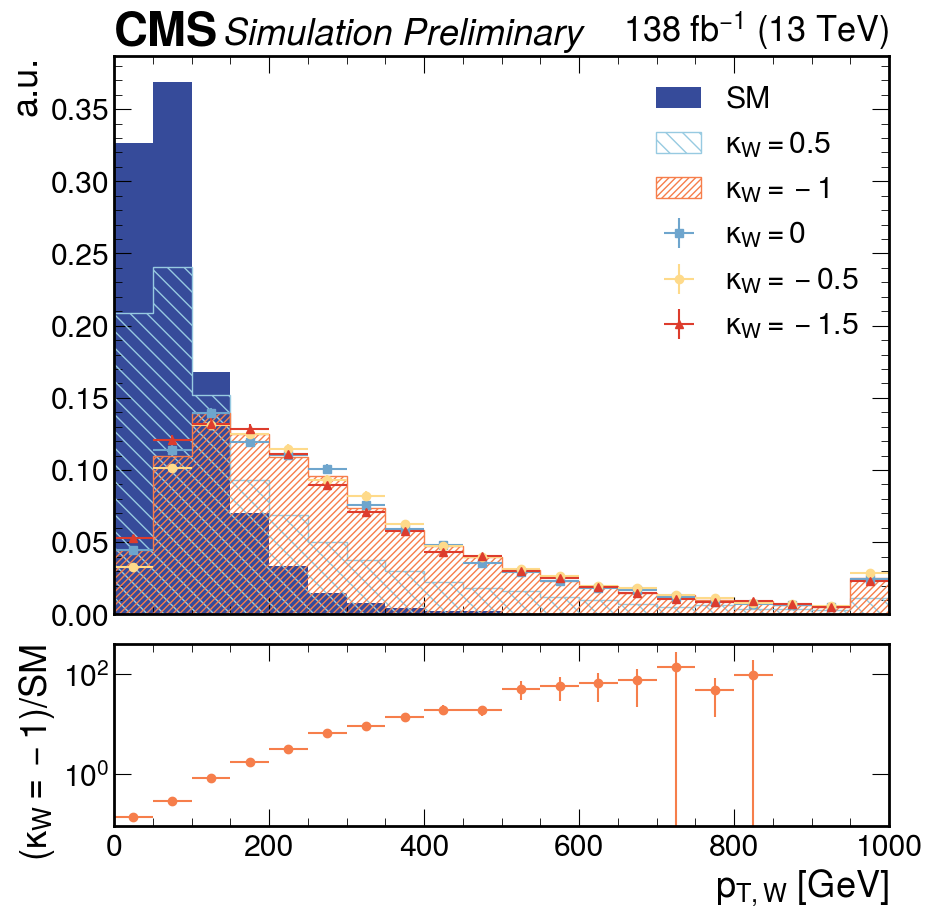

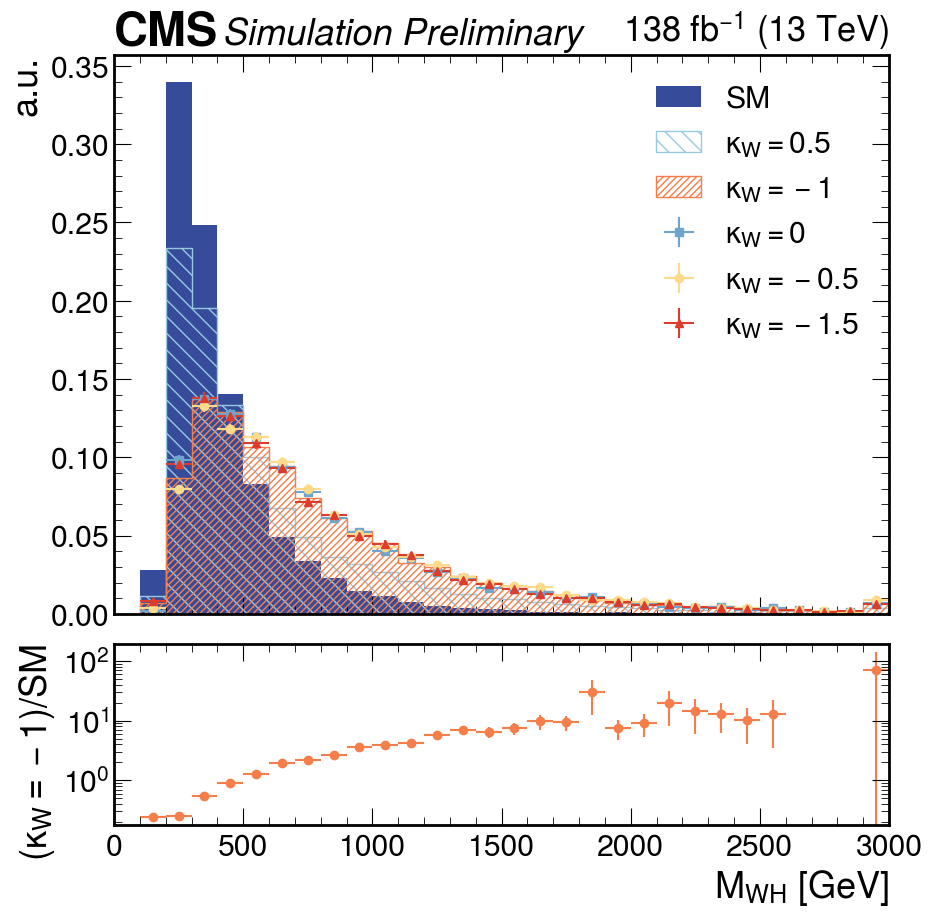

In [9]:
plot_all("H_pt", bins=np.linspace(0, 1000, 21), show_ratio=True, x_label="$p_{T,H}$ [GeV]", logy=False, norm=True, outfile=f"{PLOTS_DIR}/lhe_H_pt.pdf");
plot_all("W_pt", bins=np.linspace(0, 1000, 21), show_ratio=True, x_label="$p_{T,W}$ [GeV]", logy=False, norm=True, outfile=f"{PLOTS_DIR}/lhe_W_pt.pdf");
plot_all("M_WH", bins=np.linspace(0, 3000, 31), show_ratio=True, x_label="$M_{WH}$ [GeV]", logy=False, norm=True, outfile=f"{PLOTS_DIR}/lhe_M_WH.pdf");

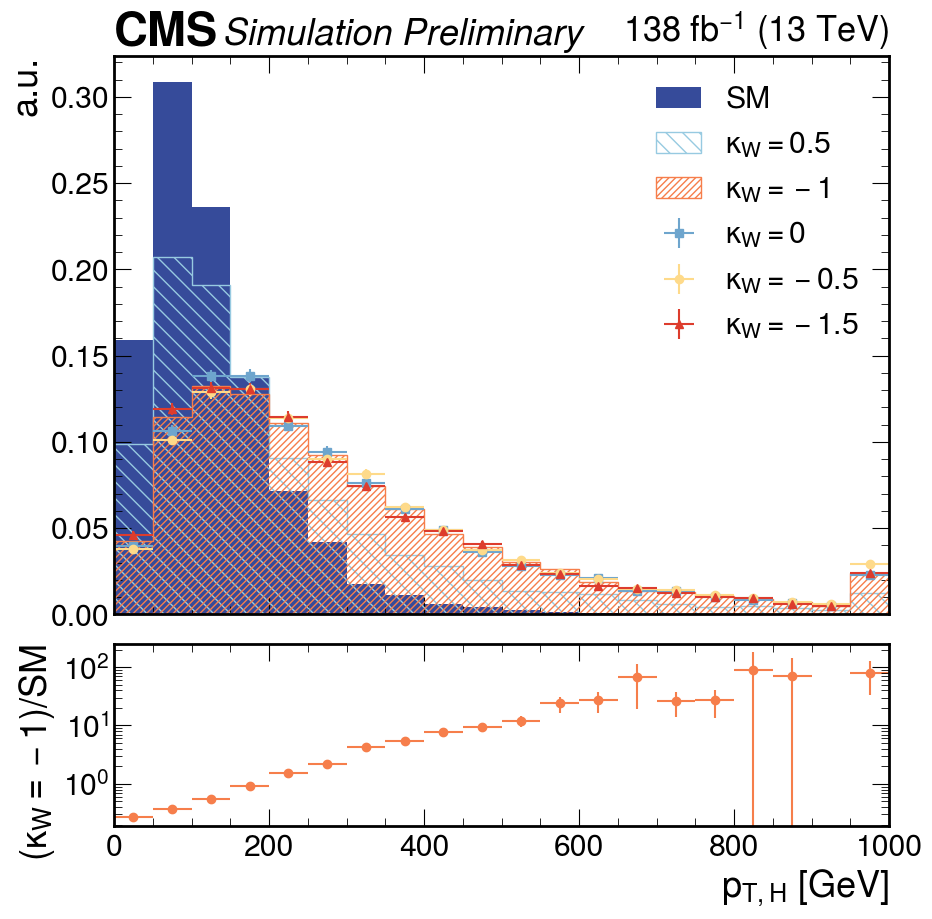

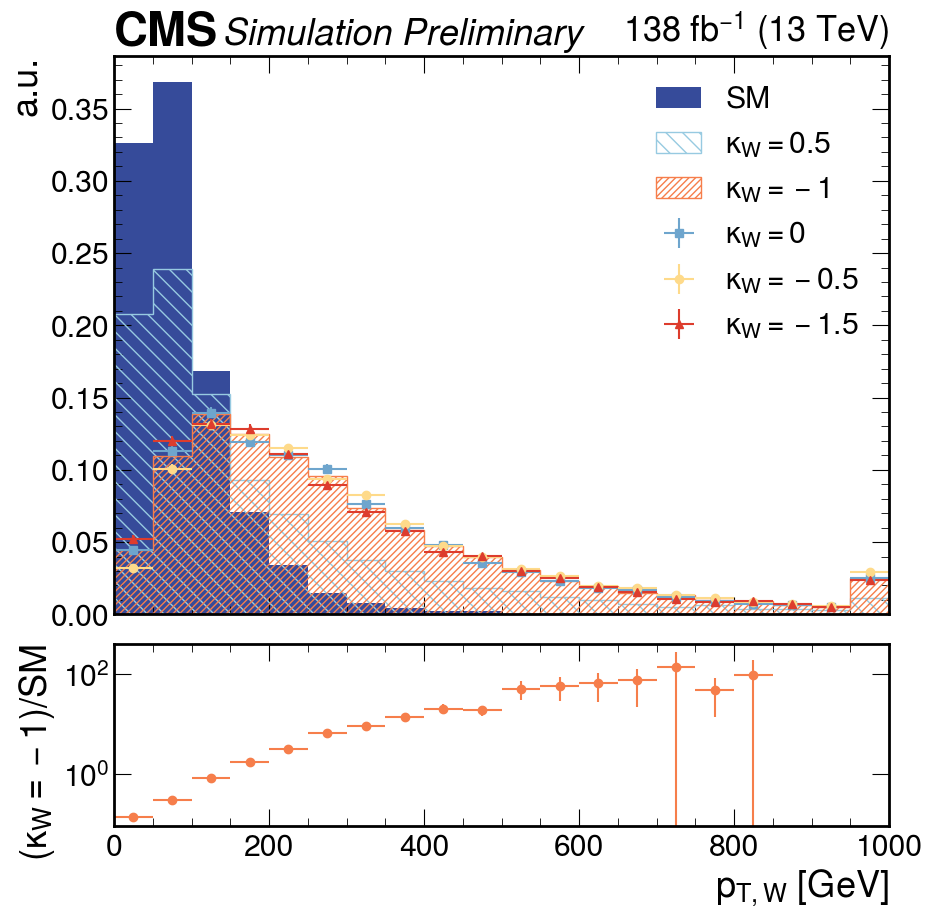

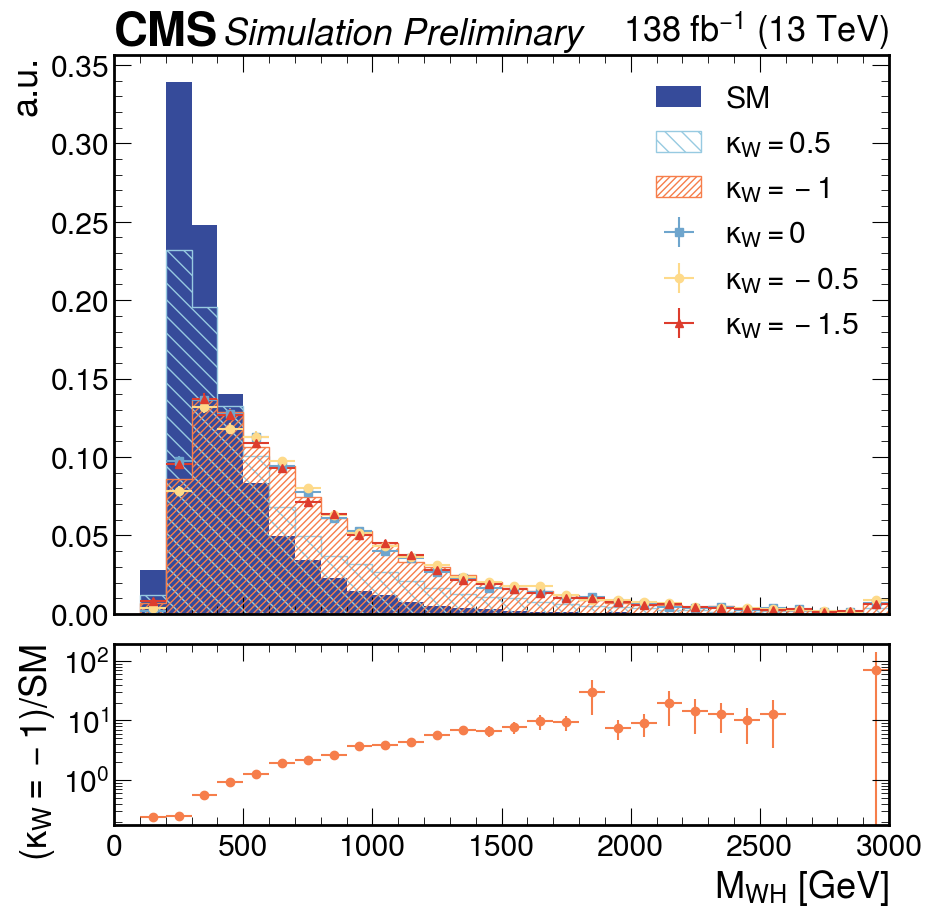

In [10]:
plot_all("H_pt", query="M_jj > 100", bins=np.linspace(0, 1000, 21), show_ratio=True, x_label="$p_{T,H}$ [GeV]", logy=False, norm=True);
plot_all("W_pt", query="M_jj > 100", bins=np.linspace(0, 1000, 21), show_ratio=True, x_label="$p_{T,W}$ [GeV]", logy=False, norm=True);
plot_all("M_WH", query="M_jj > 100", bins=np.linspace(0, 3000, 31), show_ratio=True, x_label="$M_{WH}$ [GeV]", logy=False, norm=True);

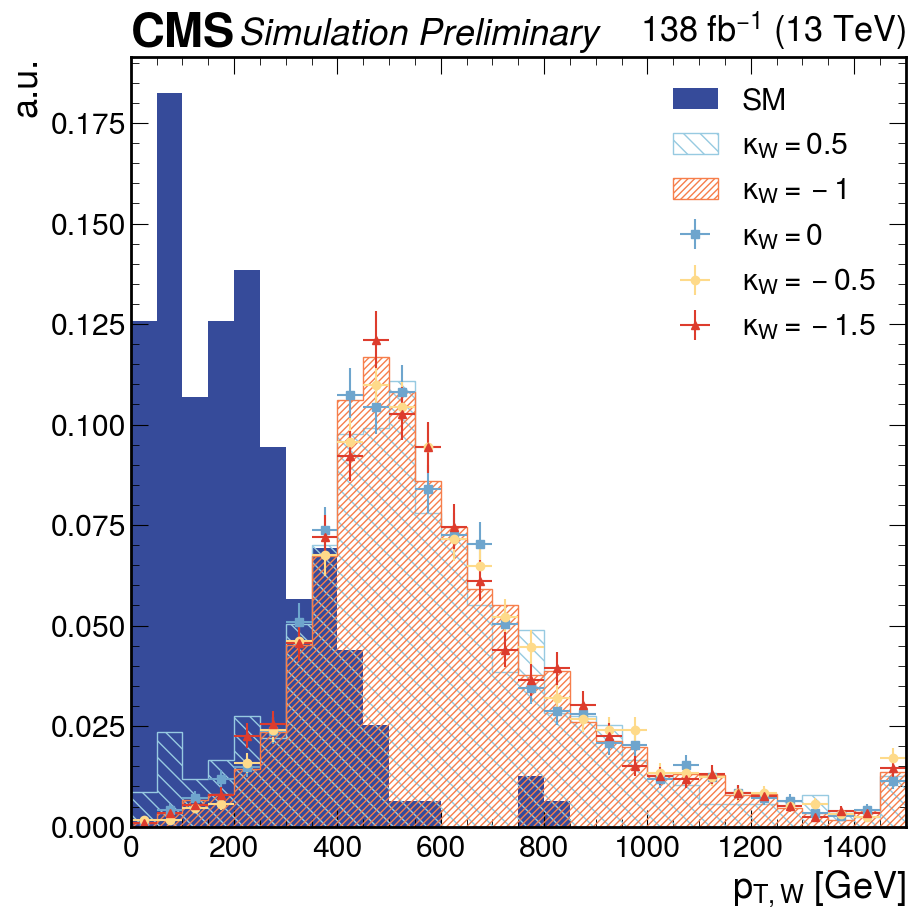

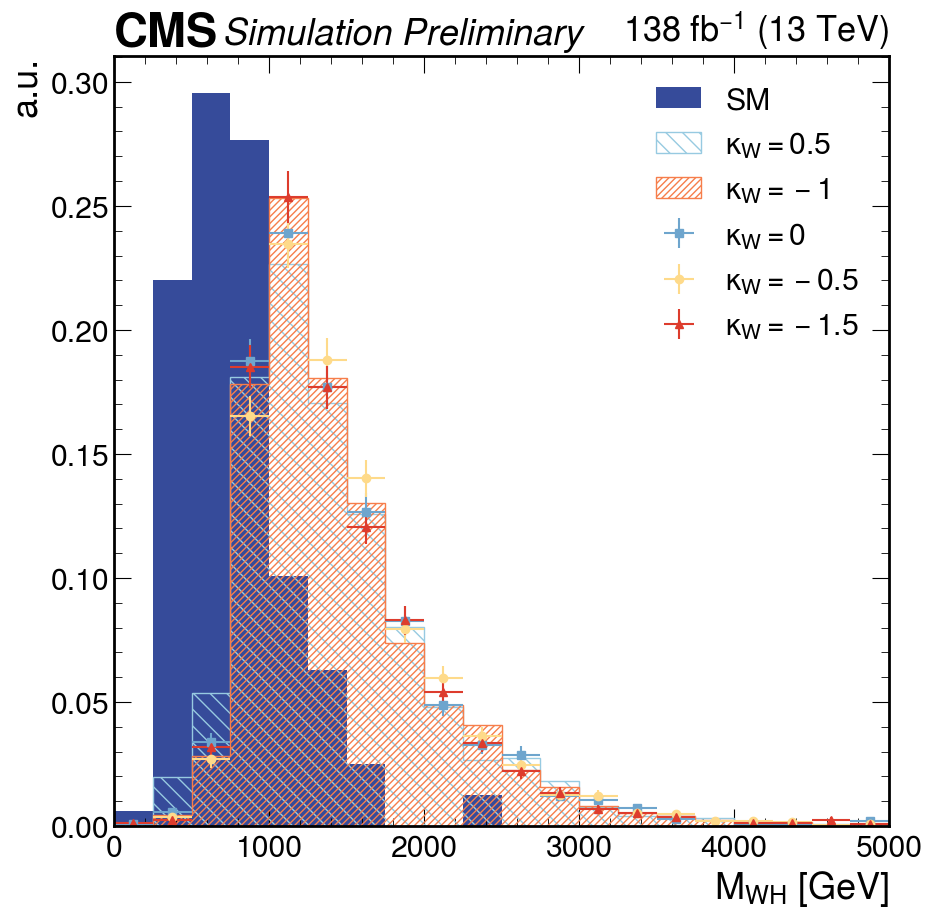

In [11]:
plot_all("W_pt", bins=np.linspace(0, 1500, 31), query="H_pt > 400", x_label="$p_{T,W}$ [GeV]", logy=False, norm=True);
plot_all("M_WH", bins=np.linspace(0, 5000, 21), query="H_pt > 400", x_label="$M_{WH}$ [GeV]", logy=False, norm=True);

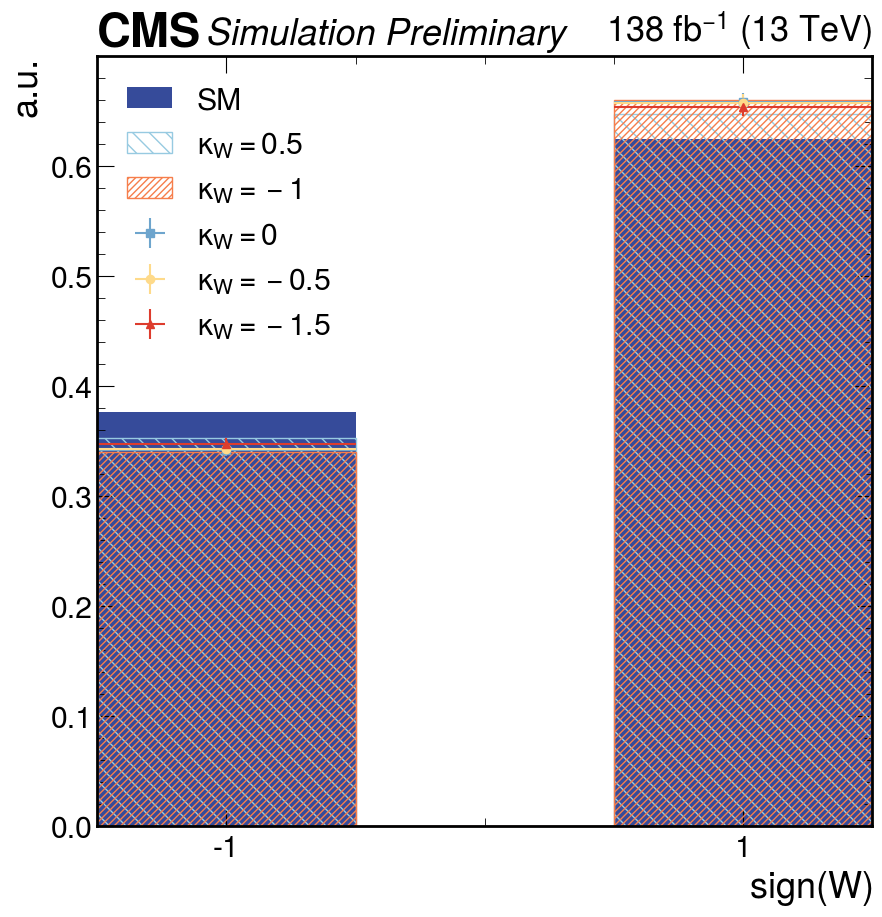

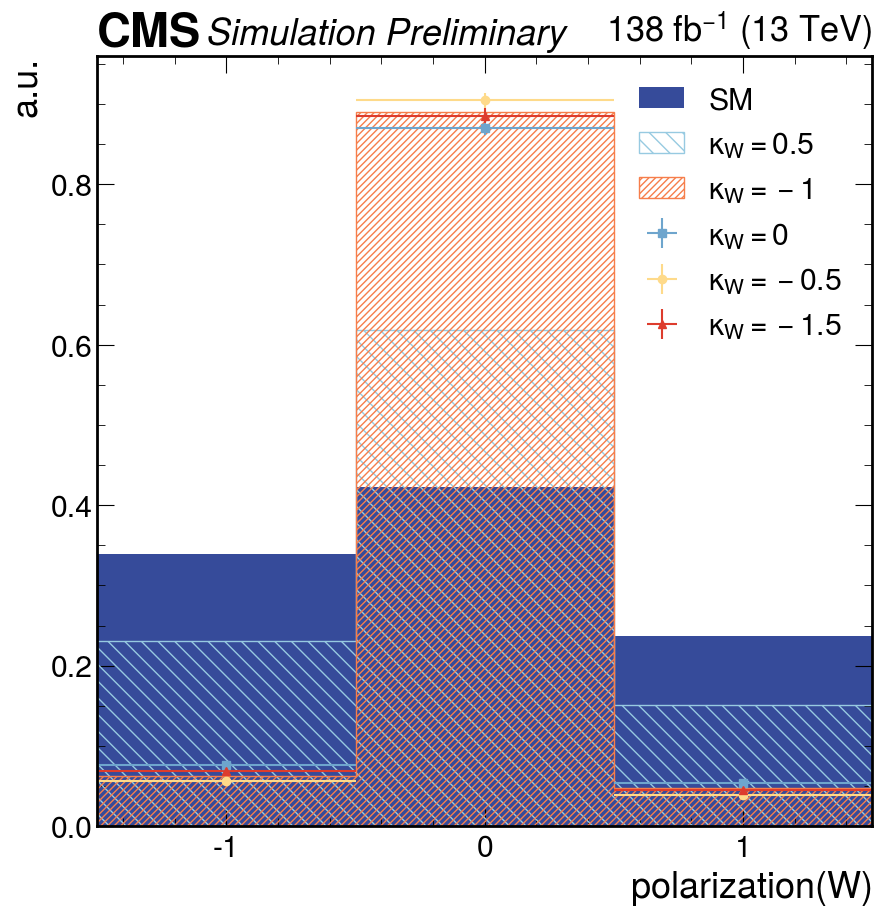

In [12]:
axes = plot_all("W_sign", bins=[-1, 0, 1, 2], x_label="$sign(W)$", transf=np.sign, norm=True)
axes.set_xticks([-0.5, 1.5]);
axes.set_xticklabels([-1, 1]);
axes.legend(loc=2);

axes = plot_all("W_pol", bins=[-1, 0, 1, 2], x_label="$polarization(W)$", transf=np.sign, norm=True)
axes.set_xticks([-0.5, 0.5, 1.5]);
axes.set_xticklabels([-1, 0, 1]);

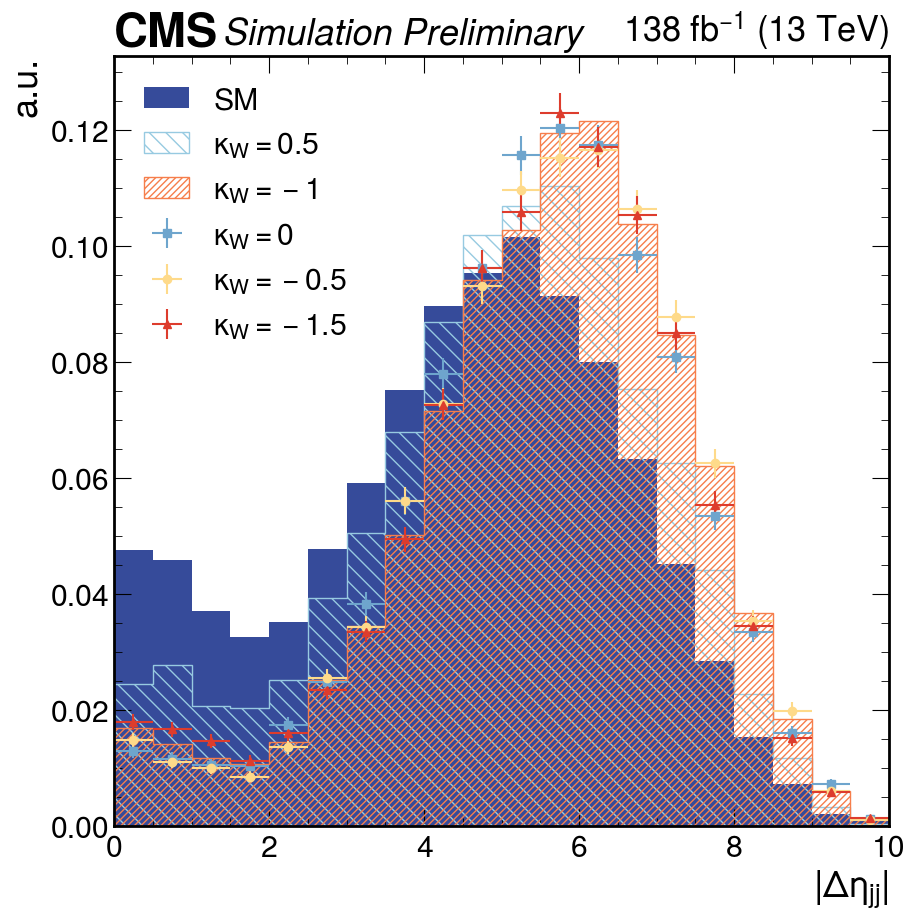

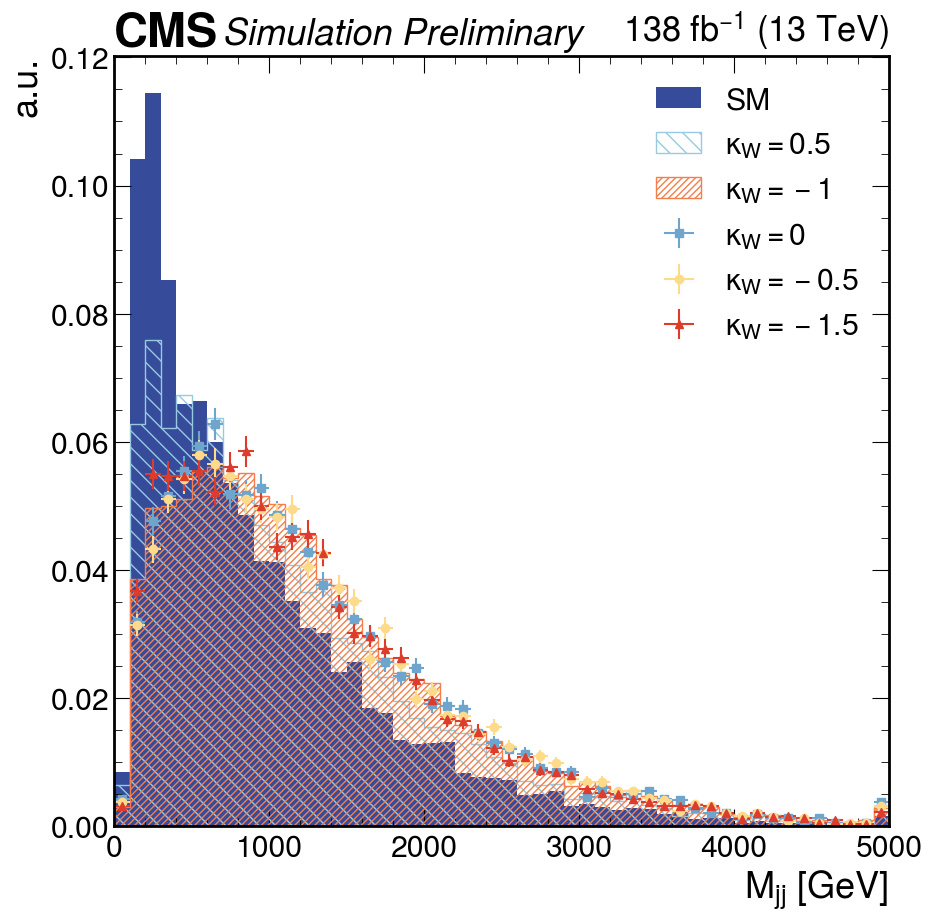

In [13]:
plot_all("deta_jj", bins=np.linspace(0, 10, 21), x_label="$|\Delta\eta_{jj}|$", transf=np.abs, norm=True);
plot_all("M_jj", bins=np.linspace(0, 5000, 51), x_label="$M_{jj}$ [GeV]", norm=True);

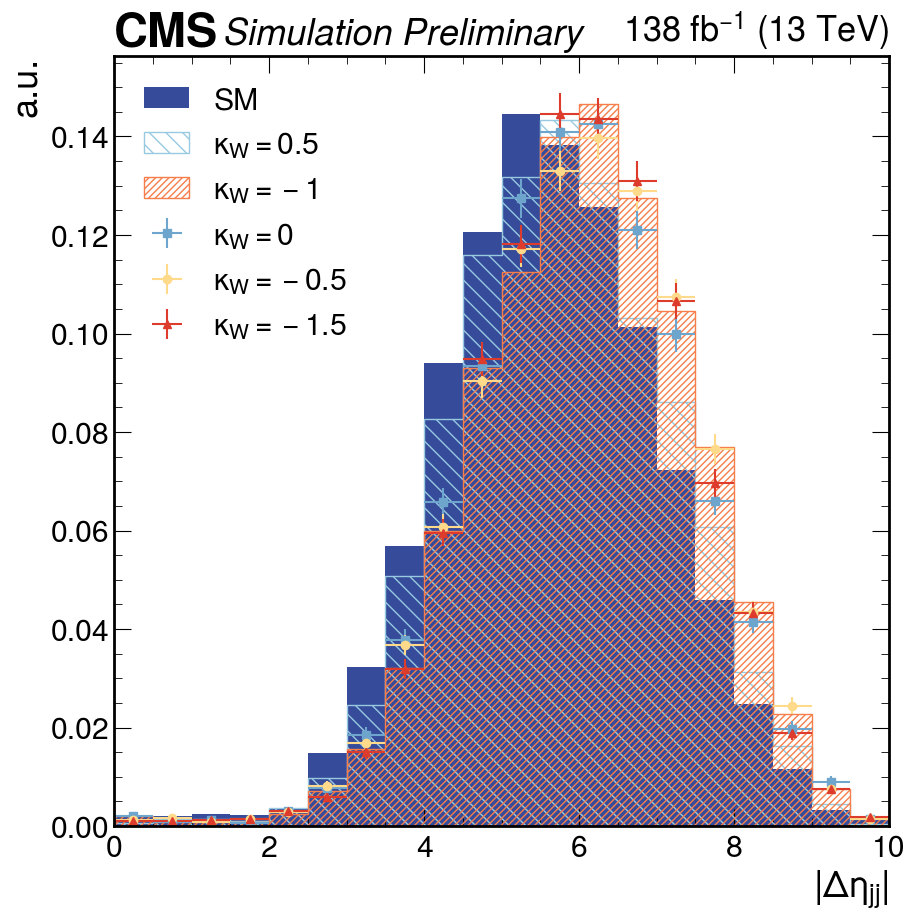

In [14]:
plot_all("deta_jj", bins=np.linspace(0, 10, 21), query="M_jj > 500", x_label="$|\Delta\eta_{jj}|$", transf=np.abs, norm=True);

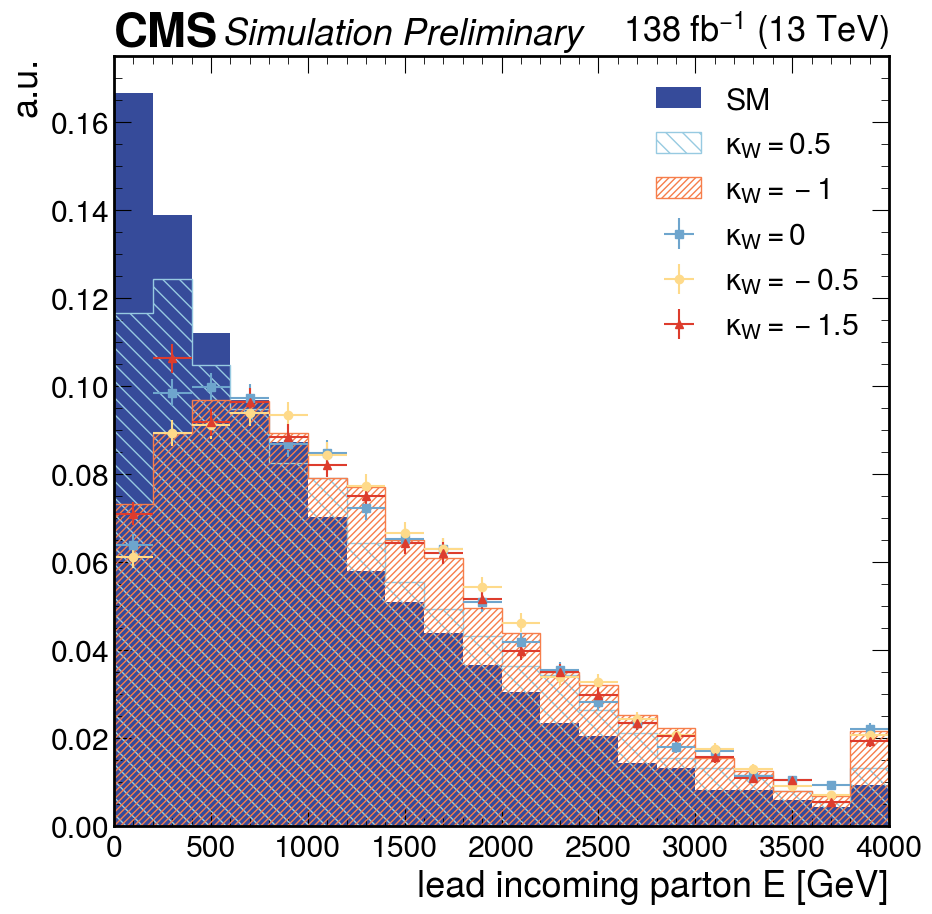

In [15]:
plot_all("ld_Q_E", bins=np.linspace(0, 4000, 21), x_label="lead incoming parton E [GeV]", logy=False, norm=True);